# Prise en main segmentation

<ipython-input-2-2e6759d1a6c8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")


torch.Size([9, 3, 520, 520])


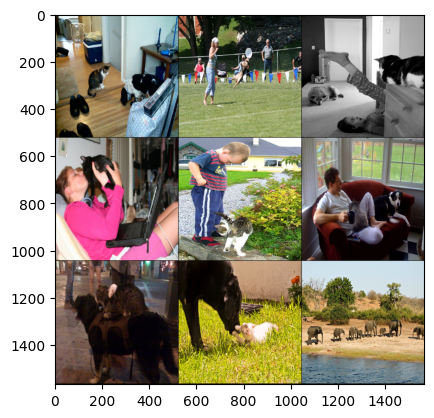

In [2]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth")

img = torch.load("coco_sample.pth")
print(img.shape)

visu = torchvision.utils.make_grid(img,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

les 9 images étant chargées, on peut leur appliquer un modèle deeplab pré-appris comme
torchvision.models.segmentation.DeepLabV3_ResNet50_Weights

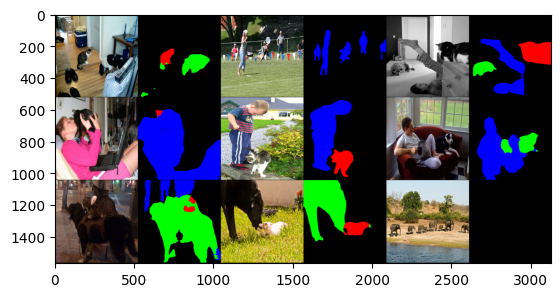

In [3]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth")

W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

# Remplaçons le classifieur par Identity pour extraire les features
net.classifier = torch.nn.Identity()


normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Charger les images et préparer les targets
img = torch.load("coco_sample.pth")[:3]  # Shape [9, 3, 520, 520]
img = torch.nn.functional.interpolate(img, size=(256,256), mode="bilinear")

with torch.no_grad():
    f_0 = net(normalize(img))["out"]
    # Exemple : inverser les canaux pour créer une cible artificielle
    f_0 = f_0[:, torch.randperm(f_0.size(1)), :, :]

# Initialiser la perturbation
attaque = torch.nn.Parameter(torch.zeros(img.shape))
optimizer = torch.optim.SGD([attaque],lr=0.005)

# Boucle d'attaque
for i in range(10):
    optimizer.zero_grad()
    x_perturbed = normalize(img + attaque)
    f = net(x_perturbed)["out"]
    loss = ((f - f_0) ** 2).sum()
    print(f"Iter {i}, Loss: {loss.item()}")
    loss.backward()
    # Conserver le gradient au lieu de le remplacer par son signe (optionnel)
    optimizer.step()
    
    # Appliquer les contraintes SANS casser le graphe de calcul
    with torch.no_grad():
        attaque.clamp_(-1/255, 1/255)
        attaque.data = torch.clamp(attaque.data, -img, 1 - img)


Iter 0, Loss: 70865840.0
Iter 1, Loss: 55340944.0
Iter 2, Loss: 58617216.0
Iter 3, Loss: 54771148.0
Iter 4, Loss: 58215036.0
Iter 5, Loss: 55536600.0
Iter 6, Loss: 58639852.0
Iter 7, Loss: 55820040.0
Iter 8, Loss: 59259128.0
Iter 9, Loss: 56039980.0


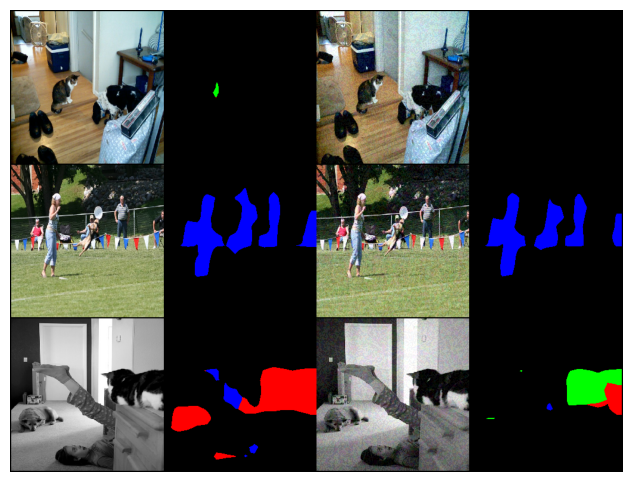

In [2]:

# Modèle pour la visualisation (avec classifieur intact)
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()
#W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
#net_vis = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

def create_pred_mask(z):
    pred = torch.zeros_like(img)
    # Personne (bleu) - classe 1
    pred[:, 0, :, :] = (z == 1).float()
    # Chat (rouge) - classe 2
    pred[:, 1, :, :] = (z == 2).float()  
    # Chien (vert) - classe 3
    pred[:, 2, :, :] = (z == 3).float()
    return pred

with torch.no_grad():
    # Utilisation du modèle de visualisation
    x_clean = normalize(img)
    z_clean = net_vis(x_clean)["out"]
    z_clean = z_clean[:,[0,8,12,15],:,:]
    _, z_clean = z_clean.max(1)

    x_perturbed = normalize(img + attaque)
    z_perturbed = net_vis(x_perturbed)["out"]
    z_perturbed = z_perturbed[:,[0,8,12,15],:,:]
    _, z_perturbed = z_perturbed.max(1)

visu = torch.cat([
    img,
    create_pred_mask(z_clean),
    img + attaque,
    create_pred_mask(z_perturbed)
], dim=-1)

visu = torchvision.utils.make_grid(visu, nrow=1)
visu = visu.permute(1, 2, 0).clamp(0,1).numpy()

plt.figure(figsize=(10, 6))
plt.imshow(visu)
plt.axis('off')
plt.show()


###Question 2

In [6]:
import os
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms

# Chargement du modèle (identique)
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()
net.classifier = torch.nn.Identity()  # Pour l'extraction de features

# Préparation de l'image de référence (personne)
def load_image(path, size=256):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    return transform(img).unsqueeze(0)  # Ajout d'une dimension batch

person_img = load_image("cible.jpg")  # Remplacez par votre chemin

# Extraction des features de référence
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
with torch.no_grad():
    f_target = net(normalize(person_img))["out"]

# Chargement de l'image à attaquer (identique)
img = torch.load("coco_sample.pth")[:3]
img = torch.nn.functional.interpolate(img, size=(256,256), mode="bilinear")

# Paramètres d'attaque (optimiseur Adam pour meilleure convergence)
attaque = torch.nn.Parameter(torch.zeros(img.shape))
optimizer = torch.optim.Adam([attaque], lr=0.01)

# Nouvelle boucle d'attaque avec cible fixe
for i in range(50):  # Plus d'itérations
    optimizer.zero_grad()
    
    # Application de la perturbation
    x_perturbed = img + attaque
    x_perturbed = torch.clamp(x_perturbed, 0, 1)  # Contrainte de validité
    
    # Calcul des features
    features = net(normalize(x_perturbed))["out"]
    
    # Loss ciblée : rapprocher les features de f_target
    loss = torch.nn.functional.mse_loss(features, f_target.repeat(features.shape[0], 1, 1, 1))
    
    # Mise à jour
    loss.backward()
    optimizer.step()
    
    # Contraintes sur la perturbation
    with torch.no_grad():
        attaque.clamp_(-0.03, 0.03)  # Augmentation de l'amplitude permise

    if i % 10 == 0:
        print(f"Iter {i}, Loss: {loss.item():.4f}")

Iter 0, Loss: 0.1314
Iter 10, Loss: 0.0424
Iter 20, Loss: 0.0328
Iter 30, Loss: 0.0274
Iter 40, Loss: 0.0238


In [ ]:
import os
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Vérification et utilisation du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Chargement des modèles
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1

# Modèle pour extraction de features
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().to(device)
net.classifier = torch.nn.Identity()  # Retire la couche de classification

# Modèle complet pour segmentation originale
original_model = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().to(device)

# Préparation des images
def load_image(path, size=256):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    return transform(Image.open(path).convert('RGB')).unsqueeze(0).to(device)

# Chargement image de référence
person_img = load_image("cible.jpg")

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with torch.no_grad():
    f_target = net(normalize(person_img))['out']
    target_feature_avg = f_target.mean(dim=(2, 3), keepdim=True).to(device)

# Chargement image à attaquer
img = torch.load("coco_sample.pth")[:3]
img = torch.nn.functional.interpolate(img, size=(256, 256), mode="bilinear").to(device)

# Génération des masques
with torch.no_grad():
    orig_seg = original_model(normalize(img))['out']
    object_mask = (orig_seg.argmax(1) != 0).float().unsqueeze(1).to(device)
    background_mask = 1 - object_mask

# Extraction des features originales
with torch.no_grad():
    orig_features = net(normalize(img))['out'].to(device)

# Configuration de l'attaque
attaque = torch.nn.Parameter(torch.zeros_like(img).to(device))
optimizer = torch.optim.Adam([attaque], lr=0.005)

for epoch in range(2):
    optimizer.zero_grad()
    
    # Application perturbation
    x_perturbed = torch.clamp(img + attaque, 0, 1)
    
    # Calcul des features
    features = net(normalize(x_perturbed))['out']
    
    # Loss sur les objets
    loss_obj = torch.nn.functional.mse_loss(
        features * object_mask, 
        target_feature_avg.expand_as(features) * object_mask
    )
    
    # Conservation du fond
    loss_bg = torch.nn.functional.mse_loss(
        features * background_mask,
        orig_features * background_mask
    )
    
    # Régularisation TV
    tv_loss = torch.sum(torch.abs(attaque[:, :, :, :-1] - attaque[:, :, :, 1:])) + \
              torch.sum(torch.abs(attaque[:, :, :-1, :] - attaque[:, :, 1:, :]))
    
    # Loss combinée
    loss = loss_obj + loss_bg + 0.1 * tv_loss
    
    # Mise à jour
    loss.backward()
    optimizer.step()
    
    # Contrainte L∞
    with torch.no_grad():
        attaque.clamp_(-0.03, 0.03)
    
    print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Obj: {loss_obj.item():.4f} | BG: {loss_bg.item():.4f} | TV: {tv_loss.item():.4f}")

# Sauvegarde du résultat
torch.save(x_perturbed, "image_attaquee.pth")

Epoch 0 | Loss: 0.0241 | Obj: 0.0241 | BG: 0.0000 | TV: 0.0000


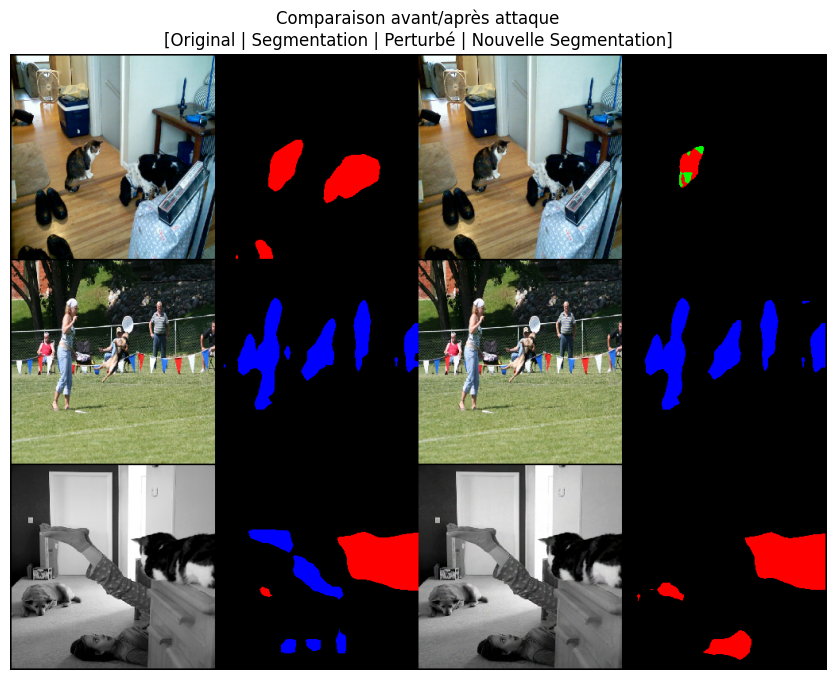

In [5]:

import matplotlib.pyplot as plt
# Modèle pour la visualisation (identique à votre version)
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

def create_pred_mask(z):
    """Version corrigée du mapping des classes"""
    pred = torch.zeros_like(img)
    
    # Personne (bleu) - classe 15 dans COCO → indice 3 dans notre sélection [0,8,12,15]
    pred[:, 0, :, :] = (z == 1).float()  # Canal bleu
    
    # Chat (rouge) - classe 8 dans COCO → indice 1
    pred[:, 1, :, :] = (z == 2).float()  # Canal rouge
    
    # Chien (vert) - classe 12 dans COCO → indice 2
    pred[:, 2, :, :] = (z == 3).float()  # Canal vert
    
    return pred

with torch.no_grad():
    # Segmentation avant attaque
    x_clean = normalize(img)
    z_clean = net_vis(x_clean)["out"]
    z_clean = z_clean[:,[0,8,12,15],:,:]  # Sélection des classes [background, chat, chien, personne]
    _, z_clean = z_clean.max(1)

    # Segmentation après attaque
    x_perturbed = normalize(torch.clamp(img + attaque, 0, 1))
    z_perturbed = net_vis(x_perturbed)["out"]
    z_perturbed = z_perturbed[:,[0,8,12,15],:,:]
    _, z_perturbed = z_perturbed.max(1)

# Création de la visualisation comparative
visu = torch.cat([
    img,
    create_pred_mask(z_clean),
    torch.clamp(img + attaque, 0, 1),
    create_pred_mask(z_perturbed)
], dim=-1)

# Affichage avec matplotlib
visu = torchvision.utils.make_grid(visu, nrow=1)
visu = visu.permute(1, 2, 0).clamp(0,1).cpu().numpy()

plt.figure(figsize=(14, 8))
plt.imshow(visu)
plt.title("Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]")
plt.axis('off')
plt.show()

Question 3

In [4]:
# --- Q3: Epsilon Analysis ---
epsilon_values = [5/255, 10/255, 15/255, 20/255]
success_rates = []

with torch.no_grad():
    f_0 = net(normalize(img))["out"]
    # Exemple : inverser les canaux pour créer une cible artificielle
    f_0 = f_0[:, torch.randperm(f_0.size(1)), :, :]
for epsilon in epsilon_values:
    attaque_epsilon = torch.nn.Parameter(torch.zeros(img.shape))
    optimizer_epsilon = torch.optim.SGD([attaque_epsilon], lr=0.005)
    
    # Attack loop with current epsilon
    for i in range(10):
        optimizer_epsilon.zero_grad()
        x_perturbed = normalize(img + attaque_epsilon)
        f = net_resnet(x_perturbed)["out"]
        loss = ((f - f_0) ** 2).sum()
        loss.backward()
        optimizer_epsilon.step()
        with torch.no_grad():
            attaque_epsilon.clamp_(-epsilon, epsilon)
            attaque_epsilon.data = torch.clamp(attaque_epsilon.data, -img, 1 - img)
    
    # Evaluate success (example metric: % of altered predictions)
    with torch.no_grad():
        original_out = net_resnet(normalize(img))["out"].argmax(1)
        perturbed_out = net_resnet(normalize(img + attaque_epsilon))["out"].argmax(1)
        success = (original_out != perturbed_out).float().mean().item()
    success_rates.append(success)
    print(f"Epsilon {epsilon*255:.0f}/255: Success Rate {success*100:.1f}%")

# Plot Q3 results
plt.figure()
plt.plot(np.array(epsilon_values)*255, success_rates, 'o-')
plt.xlabel('Epsilon (scaled by 255)')
plt.ylabel('Success Rate')
plt.title('Q3: Attack Success vs. Epsilon')
plt.show()



NameError: name 'net' is not defined

Question 4

In [ ]:
# Load a different model (MobileNet)
W_mobilenet = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net_mobilenet = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W_mobilenet).eval()

# Test original attack on MobileNet
with torch.no_grad():
    original_mobilenet = net_mobilenet(normalize(img))["out"].argmax(1)
    perturbed_mobilenet = net_mobilenet(normalize(img + attaque))["out"].argmax(1)
    transfer_success = (original_mobilenet != perturbed_mobilenet).float().mean().item()
print(f"\nQ4: Transfer Success Rate to MobileNet: {transfer_success*100:.1f}%")

Question 5

In [ ]:
# Load multiple models
net_mobilenet.classifier = torch.nn.Identity()  # For feature extraction
models = [net_resnet, net_mobilenet]

# Initialize perturbation
attaque_ensemble = torch.nn.Parameter(torch.zeros(img.shape))
optimizer_ensemble = torch.optim.SGD([attaque_ensemble], lr=0.005)

# Training loop against ensemble
print("\nTraining Ensemble Attack (Q5):")
for i in range(10):
    optimizer_ensemble.zero_grad()
    x_perturbed = normalize(img + attaque_ensemble)
    
    total_loss = 0
    for model in models:
        f = model(x_perturbed)["out"]
        loss = ((f - f_0) ** 2).sum()
        total_loss += loss
    
    total_loss.backward()
    optimizer_ensemble.step()
    
    with torch.no_grad():
        attaque_ensemble.clamp_(-10/255, 10/255)
        attaque_ensemble.data = torch.clamp(attaque_ensemble.data, -img, 1 - img)
    print(f"Iter {i}, Loss: {total_loss.item():.2f}")

# Test ensemble attack on both models
success_resnet, success_mobilenet = 0, 0
with torch.no_grad():
    # On ResNet
    original_resnet = net_resnet(normalize(img))["out"].argmax(1)
    perturbed_resnet = net_resnet(normalize(img + attaque_ensemble))["out"].argmax(1)
    success_resnet = (original_resnet != perturbed_resnet).float().mean().item()
    
    # On MobileNet
    original_mobilenet = net_mobilenet(normalize(img))["out"].argmax(1)
    perturbed_mobilenet = net_mobilenet(normalize(img + attaque_ensemble))["out"].argmax(1)
    success_mobilenet = (original_mobilenet != perturbed_mobilenet).float().mean().item()

print(f"\nQ5: Ensemble Attack Success Rates:")
print(f"- ResNet: {success_resnet*100:.1f}%")
print(f"- MobileNet: {success_mobilenet*100:.1f}%")